In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper', style='ticks', color_codes=True)

import numpy as np
import pandas as pd
import scipy
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

/Users/pstjohn/anaconda3/envs/ysi/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/pstjohn/anaconda3/envs/ysi/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Here we load the `ysi.csv` file, which contains pre-determined SMILES strings for each compound. For some additional details on how I did this, see the code in `fragdecomp.chemical_conversions`

In [2]:
ysi = pd.read_csv('ysi.csv')

This section actually computes the fragment decomposition from the SMILES strings

In [3]:
from fragdecomp.fragment_decomposition import get_fragments

fragments = ysi.SMILES.apply(get_fragments).fillna(0).astype(int)
fragments.index = ysi.SMILES

fragments.to_csv('fragments.csv')

In [4]:
fragments.shape

(441, 66)

Here we run the Bayesian linear regression with ALL data, assuming that the model error is proportional to the measurement error variance, and that fragment have a prior distribution with mean zero and standard deviation 25.

In [5]:
from fragdecomp.regression import BayesianRegressionOutlier
from fragdecomp.fragment_decomposition import get_fragments

err = ysi.YSI_err**2

reg = BayesianRegressionOutlier(fragments.values, ysi.YSI, err, prior_sd=25)
sigma, beta, y_hat = reg.sample(1000)

ysi_reg = pd.DataFrame(y_hat, columns=ysi.SMILES)
ysi_reg.to_pickle('data/ysi_raw_regression.p')

beta_hat = pd.Series(reg.beta_hat, index=['Intercept'] + list(fragments.columns))
fitted_fragments = pd.DataFrame(beta, columns=['Intercept'] + list(fragments.columns))
fitted_fragments.to_pickle('data/fragment_regression.p')

/Users/pstjohn/Dropbox/nrel_documents/Papers/stitching-paper/model/fragdecomp/regression.py:38: UserWarning: X Matrix is not full-rank
  warn("X Matrix is not full-rank")


Here we look at the distribution in the `sigma` parameter, which controls the estimated model variance. It looks like the model has around 7x the variance of the experimental measurement.

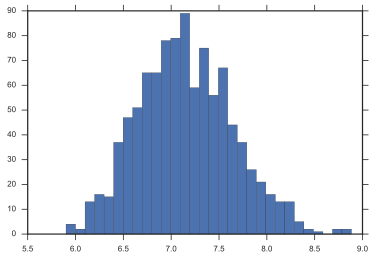

In [6]:
hist = plt.hist(sigma, bins=30)

In [7]:
import pymc3 as pm
pm.hpd(sigma)

array([ 6.16368169,  8.08937019])

/Users/pstjohn/anaconda3/envs/ysi/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


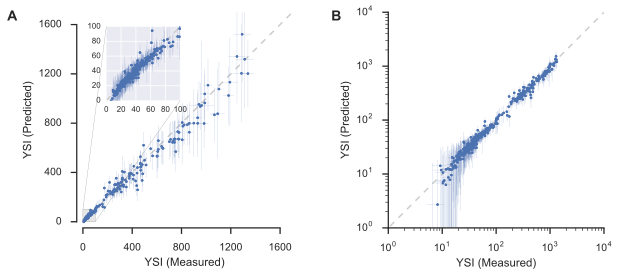

In [8]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

with sns.plotting_context('talk', font_scale=0.8):    
    fig, axs = plt.subplots(ncols=2, figsize=(9,4))

ax = axs[0]
ax_log = axs[1]

ax_log.set_yscale('log')
ax_log.set_xscale('log')

ax.set_aspect('equal', adjustable='box')
ax_log.set_aspect('equal', adjustable='box')

    
with sns.axes_style('darkgrid'):
    axins = zoomed_inset_axes(ax, 6, bbox_to_anchor=(190,260))
    
axins.set_xlim(0, 100)
axins.set_ylim(0, 100)
    
for axi in [ax, axins, ax_log]:
    axi.errorbar(ysi.YSI, y_hat.mean(0), yerr=1.96*y_hat.std(0), xerr=1.96*ysi.YSI_err/2,
             marker='.', ls='', elinewidth=0.5, markersize=5, alpha=0.25)
    axi.plot(ysi.YSI, y_hat.mean(0), '.', ms=5, color='b')
    axi.plot([0, 1E4], [0, 1E4], '--', lw=1.5, color='0.8', zorder=0)

ax.set_xlim([-50, 1700])
ax.set_ylim([-50, 1700])

ax.set_xticks(np.arange(0, 1700, 400))
ax.set_yticks(np.arange(0, 1700, 400))

ax.set_xlabel('YSI (Measured)')
ax.set_ylabel('YSI (Predicted)')
ax_log.set_xlabel('YSI (Measured)')
ax_log.set_ylabel('YSI (Predicted)')

ax_log.set_xlim([1E0, 1E4])
ax_log.set_ylim([1E0, 1E4])

mark_inset(ax, axins, loc1=2, loc2=4, fc=".9", ec="0.5")
sns.despine(ax=ax, trim=True)
sns.despine(ax=ax_log)

fig.text(.02, .91, 'A', fontweight='bold', size=14)
fig.text(.52, .91, 'B', fontweight='bold', size=14)

fig.tight_layout()

fig.savefig('figures/ppc_linear_inset.svg')

To make sure we're not overfitting the data, we perform a leave-one-out cross-validation.

In [9]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

X = fragments.values
y = ysi.YSI

In [10]:
# c_v_predict = {}

# for train_index, test_index in tqdm(loo.split(X), total=len(y)):
    
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
    
#     reg = BayesianRegressionOutlier(X_train, y_train, err[train_index], prior_sd=25)
#     sigma, beta, y_hat = reg.sample(1000)
#     test_pred, test_hpd = reg.predict(X_test, beta)
    
#     c_v_predict[ysi.SMILES[test_index].iloc[0]] = {
#         'YSI': test_pred,
#         'YSI_err': test_hpd,
#         'Outlier': reg.is_outlier(X_test)[0]
#     }

# cv_results = pd.DataFrame(c_v_predict).T.loc[ysi.SMILES]
# cv_results.to_pickle('data/cv_results.p')

cv_results = pd.read_pickle('data/cv_results.p')

In [11]:
cv_results.head()

,Outlier,YSI,YSI_err
c1ccc(-c2ccccc2-c2ccccc2)cc1,False,[1196.58290498],"[[77.1317835825, 75.8196785385]]"
c1cc2c3c(c1)ccc1cccc(c13)C2,False,[1323.67594837],"[[87.9143786442, 99.5090208397]]"
c1ccc2c(c1)-c1cccc3cccc-2c13,False,[1532.5919407],"[[84.0255111283, 83.1368581302]]"
c1ccc(-c2cccc(-c3ccccc3)c2)cc1,False,[1207.63822171],"[[73.3291867789, 76.0764773775]]"
c1cc2ccc3cccc4ccc(c1)c2c34,False,[1335.13542496],"[[77.9990420281, 85.3938762346]]"


/Users/pstjohn/anaconda3/envs/ysi/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


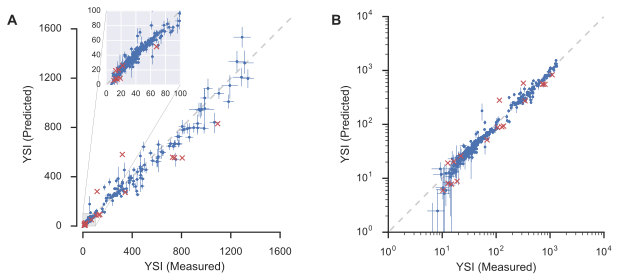

In [12]:
not_outlier = ~cv_results.Outlier.values

with sns.plotting_context('talk', font_scale=0.8):    
    fig, axs = plt.subplots(ncols=2, figsize=(9,4))

ax = axs[0]
ax_log = axs[1]

ax_log.set_yscale('log')
ax_log.set_xscale('log')

ax.set_aspect('equal', adjustable='box')
ax_log.set_aspect('equal', adjustable='box')

    
with sns.axes_style('darkgrid'):
    axins = zoomed_inset_axes(ax, 6, bbox_to_anchor=(190,280))
    
axins.set_xlim(0, 100)
axins.set_ylim(0, 100)
    
for axi in [ax, axins, ax_log]:
    axi.errorbar(ysi[not_outlier].YSI, cv_results[not_outlier].YSI, xerr=1.96*ysi[not_outlier].YSI_err/2,
                   yerr=np.concatenate(cv_results[not_outlier].YSI_err.values).T,
                   marker='.', ls='', elinewidth=0.5, markersize=5, label='')

    axi.plot(ysi[not_outlier].YSI, cv_results[not_outlier].YSI, '.', ms=5, color='b')

    axi.plot(ysi[~not_outlier].YSI, cv_results[~not_outlier].YSI,
                   marker='x', ls='', markersize=5, color='r', label='Outlier', markeredgewidth=1, alpha=0.5)

    axi.plot([0, 1E4], [0, 1E4], '--', lw=1.5, color='0.8', zorder=0)

ax.set_xlim([-50, 1700])
ax.set_ylim([-50, 1700])

ax.set_xticks(np.arange(0, 1700, 400))
ax.set_yticks(np.arange(0, 1700, 400))

ax.set_xlabel('YSI (Measured)')
ax.set_ylabel('YSI (Predicted)')
ax_log.set_xlabel('YSI (Measured)')
ax_log.set_ylabel('YSI (Predicted)')

ax_log.set_xlim([1E0, 1E4])
ax_log.set_ylim([1E0, 1E4])


mark_inset(ax, axins, loc1=2, loc2=4, fc=".9", ec="0.5")
sns.despine(ax=ax, trim=True)
sns.despine(ax=ax_log)


fig.text(.02, .91, 'A', fontweight='bold', size=14)
fig.text(.52, .91, 'B', fontweight='bold', size=14)


fig.tight_layout()
fig.savefig('figures/loo_means.svg')

Here we report a number of statistical metrics for the leave-one-out regression for later quoting in the manuscript.

In [13]:
from sklearn.metrics import median_absolute_error, mean_absolute_error

In [14]:
# Mean absolute error for all inlier points
mean_absolute_error(cv_results[not_outlier].YSI, ysi[not_outlier].YSI)

19.109963962525836

In [15]:
# Mean absolute error for all points in the high-ysi range
mean_absolute_error(cv_results[not_outlier & (ysi.Ref != 3).values].YSI,
                    ysi[not_outlier & (ysi.Ref != 3).values].YSI)

45.67558187084768

In [16]:
# Mean absolute error for all points in the low-ysi range
mean_absolute_error(cv_results[not_outlier & (ysi.Ref == 3).values].YSI,
                    ysi[not_outlier & (ysi.Ref == 3).values].YSI)

3.687976038219142

Same breakouts, but with *median* absolute error rather than mean. This downplays the effect of significant misses.

In [17]:
median_absolute_error(cv_results[not_outlier].YSI, ysi[not_outlier].YSI)

3.7108995948205692

In [18]:
median_absolute_error(cv_results[not_outlier & (ysi.Ref != 3).values].YSI,
                      ysi[not_outlier & (ysi.Ref != 3).values].YSI)

28.615413089989346

In [19]:
median_absolute_error(cv_results[not_outlier & (ysi.Ref == 3).values].YSI,
                      ysi[not_outlier & (ysi.Ref == 3).values].YSI)

2.3470924503269224

In particular, this last number is better than our previous performance in the *Energy & Fuels* in press paper.

In [20]:
from pymc3 import hpd

ysi['YSI_pred'] = cv_results.YSI.apply(lambda x: x[0]).values

ysi['YSI_pred_low'] = ysi.YSI_pred - np.concatenate(cv_results.YSI_err.values)[:,0]
ysi['YSI_pred_high'] = ysi.YSI_pred + np.concatenate(cv_results.YSI_err.values)[:,1]
ysi['cv_outlier'] = cv_results.Outlier.values
ysi.to_csv('data/ysi_predictions.csv', index=False)

In [21]:
ysi_red = ysi[~ysi.cv_outlier].copy()
# ysi_bad = ysi_red[(ysi_red.YSI < ysi_red.YSI_pred_low) | (ysi_red.YSI > ysi_red.YSI_pred_high)]

In [22]:
z_stat = (ysi_red.YSI - ysi_red.YSI_pred) / np.sqrt((ysi_red.YSI_err ** 2 + (ysi_red.YSI_pred_high - ysi_red.YSI_pred_low)))
p_val = scipy.stats.norm.sf(abs(z_stat))*2
ysi_red['p'] = p_val

In [23]:
ysi_outlier_table = ysi_red.sort_values('p').head(10)

ysi_outlier_table

,Species,CAS,Ref,Type,YSI,YSI_err,SMILES,YSI_pred,YSI_pred_low,YSI_pred_high,cv_outlier,p
122,styrene,100-42-5,1.0,aromatic,174.0,7.7,C=Cc1ccccc1,314.771207,289.789241,337.650064,False,4.043667e-42
115,phenylacetylene,536-74-3,1.0,aromatic,216.3,9.3,C#Cc1ccccc1,356.589544,328.474431,386.657971,False,1.957092e-31
185,2-pentyne,627-21-4,3.0,alkynes/alkadienes,54.7,2.0,CC#CCC,177.971304,117.162933,242.565715,False,2.310735e-27
61,(2-propynyl)-benzene,10147-11-2,1.0,aromatic,443.7,17.1,C#CCc1ccccc1,254.337419,240.458493,265.728635,False,2.298011e-26
60,naphthalene,91-20-3,1.0,aromatic,466.1,8.4,c1ccc2ccccc2c1,568.533460,535.284668,604.282254,False,4.286474e-18
64,(2-methyl-1-propenyl)-benzene,768-49-0,1.0,aromatic,436.9,16.6,CC(C)=Cc1ccccc1,283.432105,261.196293,304.327281,False,8.202873e-18
431,1-methyl-1-cyclohexene,591-49-1,NaN,cyclic alkenes,62.0,3.0,CC1=CCCCC1,108.370777,98.374743,118.806430,False,1.258330e-17
55,(1-butynyl)-benzene,622-76-4,1.0,aromatic,480.8,18.4,CCC#Cc1ccccc1,324.170228,299.001419,351.982418,False,2.459967e-15
101,"1,4-diethylbenzene",105-05-5,1.0,aromatic,270.7,11.0,CCc1ccc(CC)cc1,367.165783,345.475105,391.995368,False,9.114041e-14
52,azulene,275-51-4,2.0,aromatic,492.3,19.0,c1ccc2cccc-2cc1,643.074778,606.841846,684.025920,False,5.899530e-13


In [24]:
ysi_outlier_table['%err'] = (100 * (ysi_outlier_table.YSI - ysi_outlier_table.YSI_pred) / ysi_outlier_table.YSI).round(0)
ysi_outlier_table['ysi_str'] = ysi_outlier_table.apply(lambda x: '${:.1f} \\pm {:.1f}$'.format(x.YSI, x.YSI_err), 1)
ysi_outlier_table['ysi_str_p'] = ysi_outlier_table.apply(lambda x: '${:.1f} \\pm {:.1f}$'.format(x.YSI_pred, np.sqrt(x.YSI_pred_high - x.YSI_pred_low)), 1)

In [25]:
print(ysi_outlier_table.set_index('Species').loc[:, ['CAS', 'Type', 'ysi_str', 'ysi_str_p', '%err']].round(1).to_latex())

\begin{tabular}{lllllr}
\toprule
{} &         CAS &                Type &           ysi\_str &         ysi\_str\_p &   \%err \\
Species                       &             &                     &                   &                   &        \\
\midrule
styrene                       &    100-42-5 &            aromatic &   \$174.0 \textbackslashpm 7.7\$ &   \$314.8 \textbackslashpm 6.9\$ &  -81.0 \\
phenylacetylene               &    536-74-3 &            aromatic &   \$216.3 \textbackslashpm 9.3\$ &   \$356.6 \textbackslashpm 7.6\$ &  -65.0 \\
2-pentyne                     &    627-21-4 &  alkynes/alkadienes &    \$54.7 \textbackslashpm 2.0\$ &  \$178.0 \textbackslashpm 11.2\$ & -225.0 \\
(2-propynyl)-benzene          &  10147-11-2 &            aromatic &  \$443.7 \textbackslashpm 17.1\$ &   \$254.3 \textbackslashpm 5.0\$ &   43.0 \\
naphthalene                   &     91-20-3 &            aromatic &   \$466.1 \textbackslashpm 8.4\$ &   \$568.5 \textbackslashpm 8.3\$ &  -22.0 \\
(2-me

In [29]:
ysi[ysi.Species.str.contains('cyclohexene')].round(1)

,Species,CAS,Ref,Type,YSI,YSI_err,SMILES,YSI_pred,YSI_pred_low,YSI_pred_high,cv_outlier
221,cyclohexene,110-83-8,3.0,cyclic alkenes,45.6,2.0,C1=CCCCC1,71.1,65.6,76.8,False
431,1-methyl-1-cyclohexene,591-49-1,NaN,cyclic alkenes,62.0,3.0,CC1=CCCCC1,108.4,98.4,118.8,False
432,1-tert-butyl-1-cyclohexene,3419-66-7,NaN,cyclic alkenes,161.0,5.0,CC(C)(C)C1=CCCCC1,117.1,106.1,125.9,False
433,1-phenyl-1-cyclohexene,771-98-2,NaN,cyclic alkenes,468.0,14.0,C1=C(c2ccccc2)CCCC1,390.4,276.2,485.0,False
435,3-methyl-1-cyclohexene,591-48-0,NaN,cyclic alkenes,85.0,4.0,CC1C=CCCC1,77.9,72.9,83.7,False
436,4-methyl-1-cyclohexene,591-47-9,NaN,cyclic alkenes,61.0,3.0,CC1CC=CCC1,80.4,74.6,85.7,False


In [91]:
ysi.set_index('SMILES')[fragments['[C]-[C](-[C])=[C] | (Ring)'] != 0]

,Species,CAS,Ref,Type,YSI,YSI_err,YSI_pred,YSI_pred_low,YSI_pred_high,cv_outlier
SMILES,,,,,,,,,,
CC1=Cc2ccccc2C1,2-methylindene,2177-47-1,1.0,aromatic,500.1,19.1,495.321865,439.989815,552.246349,False
CC1=CC2C3CC(C=C3C)C2C1,methylcyclopentadiene dimer,26472-00-4,2.0,aromatic,189.2,8.2,202.861354,179.749953,224.819892,False
CC1=CCC=CC1,"1-methyl-1,4-cyclohexadiene",4313-57-9,1.0,aliphatic,175.6,7.7,112.164705,102.686800,122.212638,False
CC1=CCCC1,1-methylcyclopentene,693-89-0,3.0,cyclic alkenes,96.5,2.8,79.984539,69.550512,90.877005,False
CC1=CCCCC1,1-methyl-1-cyclohexene,591-49-1,NaN,cyclic alkenes,62.0,3.0,108.370777,98.374743,118.806430,False
CC(C)(C)C1=CCCCC1,1-tert-butyl-1-cyclohexene,3419-66-7,NaN,cyclic alkenes,161.0,5.0,117.053629,106.083380,125.929362,False
